# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-11-02*

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../src/')
from namelist import *
from mask import polygon_to_mask

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 计算平均值数组

In [2]:
var = 'SOL_RAD'
month = "Sep"

low_years = np.array([2016,2015,2014]) # 此处年份倒置是为了方便后续创建dataarray时取用时间维度
high_years = np.array([2022,2021,2019])

low_files  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in low_years]
high_files = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in high_years]
low_files

['D:/data/Graduation/processed/Sep_2016/Sep_2016_mcip.nc',
 'D:/data/Graduation/processed/Sep_2015/Sep_2015_mcip.nc',
 'D:/data/Graduation/processed/Sep_2014/Sep_2014_mcip.nc']

In [3]:
def average_data(filelist, var):
    """
    This function takes a list of file names and a variable name as input,
    reads the data from each file, computes an average over all files, and returns
    an xarray DataArray with the averaged data.
    
    Parameters
    ----------
    filelist : list of str
        List of file names to read.
        
    var : str
        Name of the variable to extract from the datasets.
        
    Returns
    -------
    avg_data : xarray.DataArray
        Averaged data as an xarray DataArray.
    """
    select_data = []
    for file in filelist:
        ds = xr.open_dataset(file)
        data = ds[var][:,0,:,:] # Ground level
        select_data.append(data)
        ds.close()
    
    #// combined = xr.concat(select_data, dim='data_array')
    #// averaged = combined.mean(dim='data_array')

    averaged = (select_data[0].values 
                + select_data[1].values 
                + select_data[2].values) / 3
    
    avg_data = xr.DataArray(
        averaged,
        dims=data.dims,
        coords=data.coords,
        name=var
    )
    return avg_data

In [4]:
avg_low  = average_data(low_files, var)
avg_high = average_data(high_files, var)

## 计算珠三角范围平均

In [5]:
shp = gpd.read_file(shpPRD)
lon = avg_low.longitude
lat = avg_low.latitude

mask    = polygon_to_mask(shp.geometry[0], lon, lat)
mask_da = xr.DataArray(mask, dims=('y','x'))

masked_low  = avg_low.where(mask_da)
mean_low    = masked_low.mean(dim=('x','y'),skipna=True)
masked_high = avg_high.where(mask_da)
mean_high   = masked_high.mean(dim=('x','y'),skipna=True)

# 创建掩码，过滤掉无穷大值
inf_mask  = np.isfinite(mean_low)
mean_low  = mean_low.where(inf_mask)
inf_mask  = np.isfinite(mean_high)
mean_high = mean_high.where(inf_mask)

In [8]:
# max
max_low_day  = mean_low.resample(time='D').max(skipna=True)
# percentile
low_90per = mean_low.resample(time='D').quantile(0.9,skipna=True)
low_80per = mean_low.resample(time='D').quantile(0.8,skipna=True)

# max
max_high_day  = mean_high.resample(time='D').max(skipna=True)
# percentile
high_90per = mean_high.resample(time='D').quantile(0.9,skipna=True)
high_80per = mean_high.resample(time='D').quantile(0.8,skipna=True)

* 折线图：90百分位
* 阴影：max~80百分位

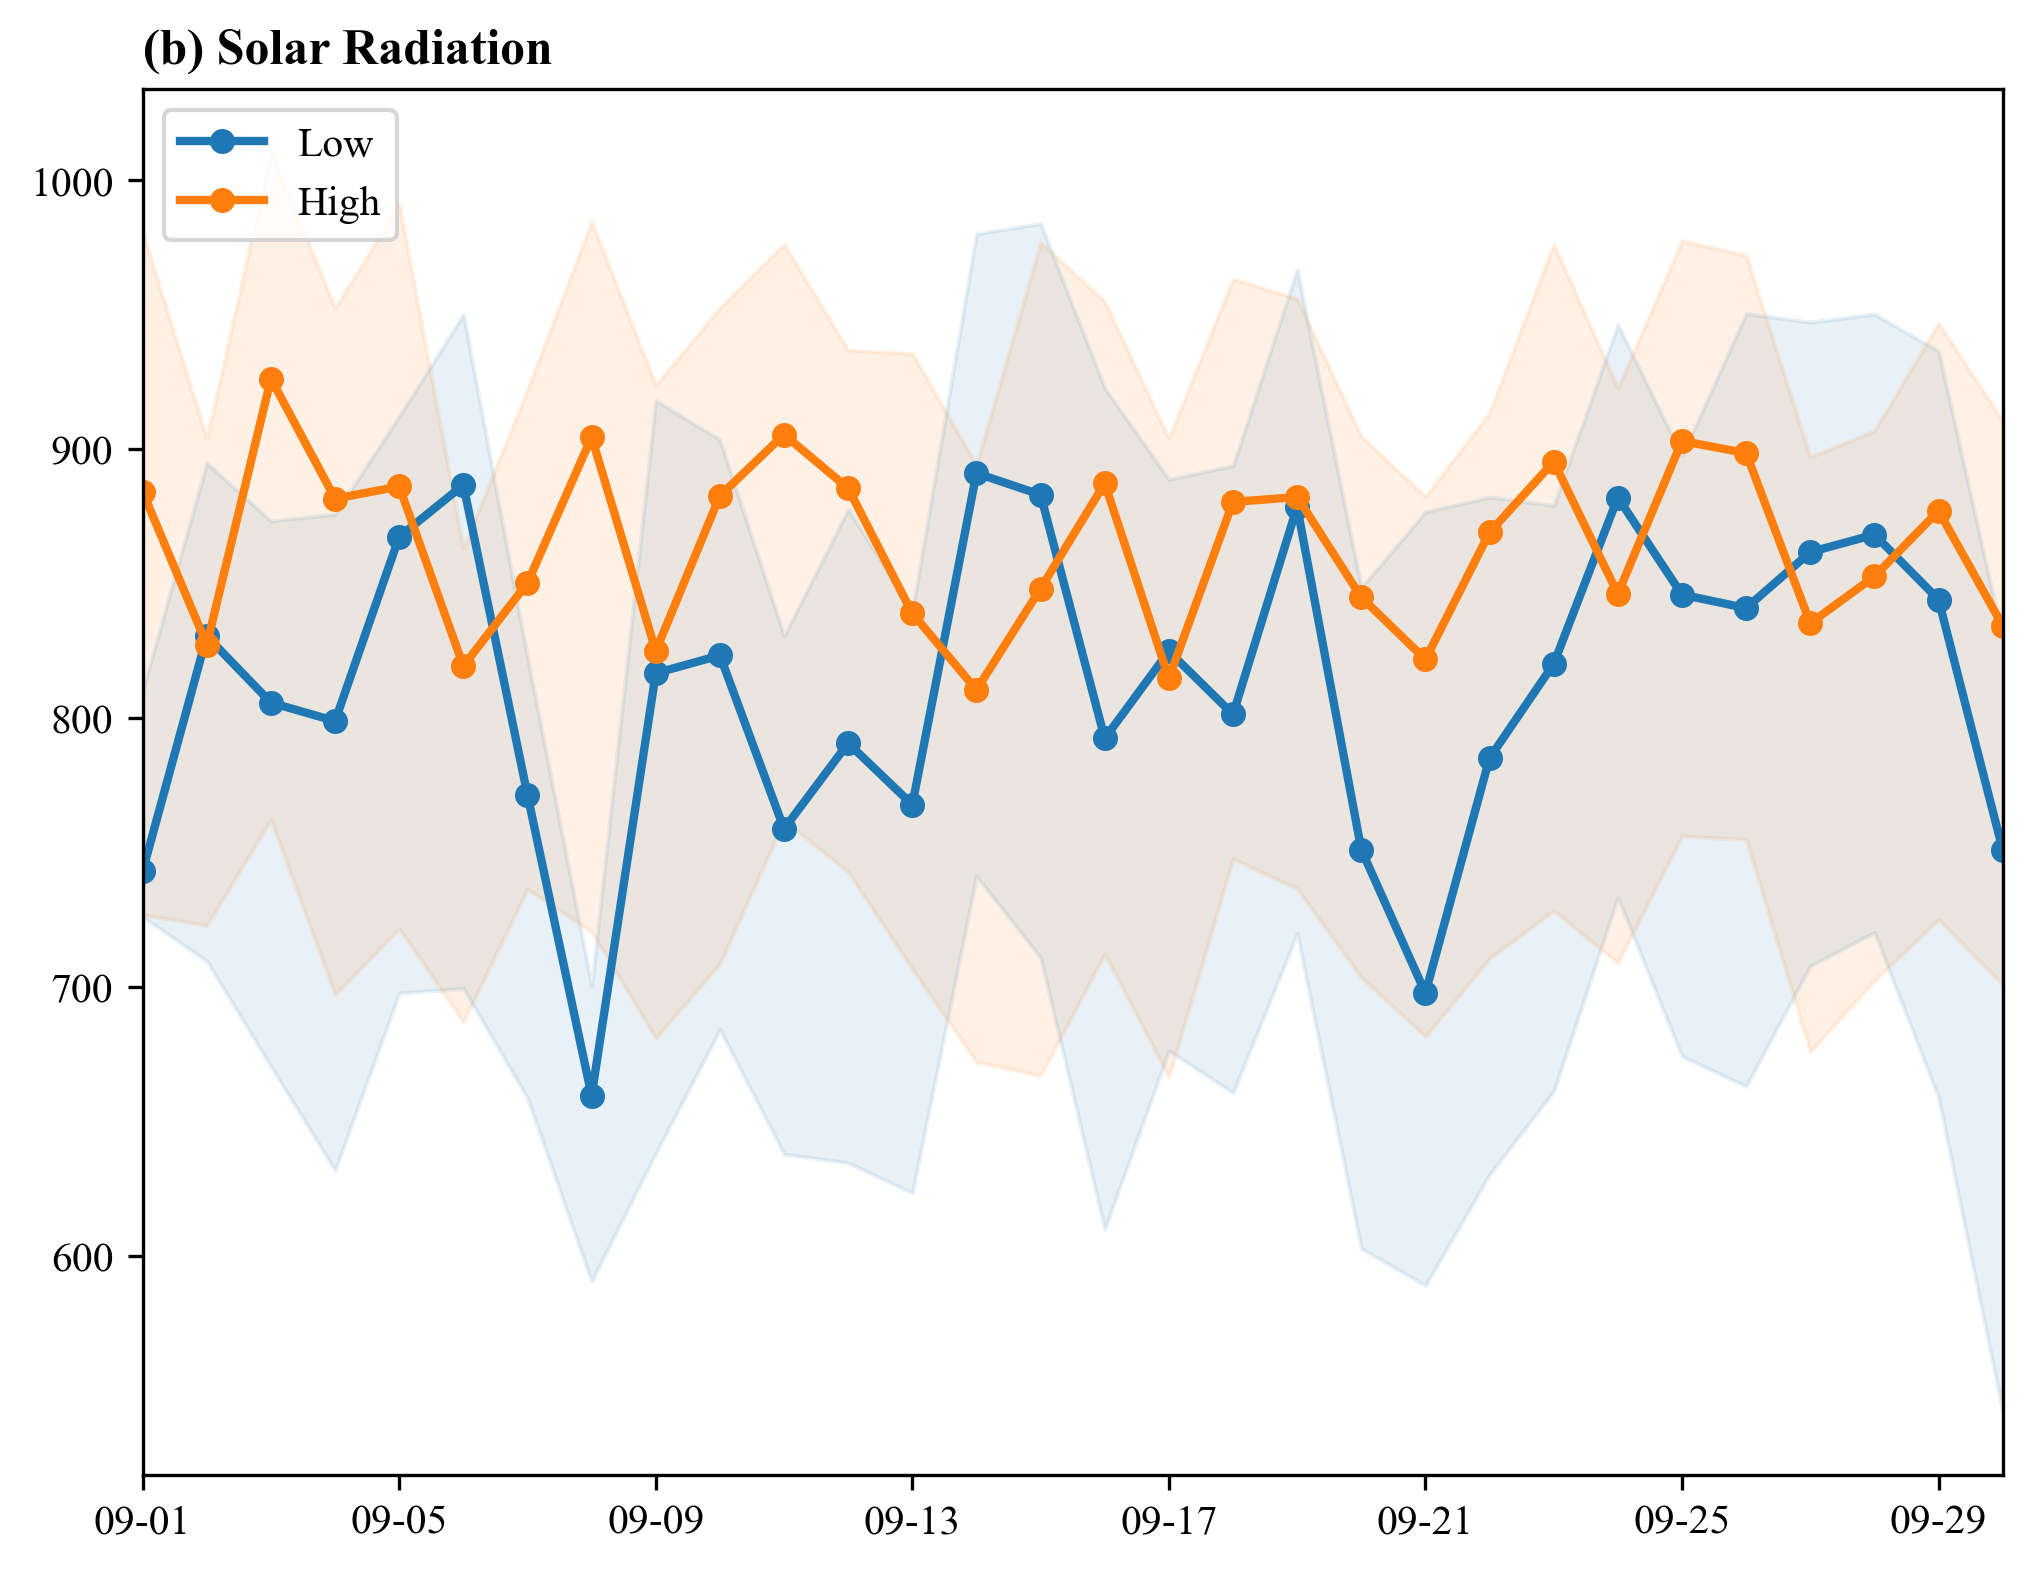

In [11]:
fig = plt.figure(figsize=(8,6),dpi=300)
ax = fig.subplots(1,1)

xx = np.arange(0,len(max_low_day.time),1)
# lower years
ax.plot(xx,low_90per,color='tab:blue',linewidth=2,label='Low',marker='.',markersize=10)
ax.fill_between(xx,max_low_day,low_80per,color='tab:blue',alpha=0.1)

ax.plot(xx,high_90per,color='tab:orange',linewidth=2,label='High',marker='.',markersize=10)
ax.fill_between(xx,max_high_day,high_80per,color='tab:orange',alpha=0.1)

# ticks and labels
ax.set_xlim([0,len(max_low_day.time)-1])
# ax.set_ylim(24,37)
ax.set_xticks(xx[::4])
ax.set_xticklabels(pd.date_range('2023-09-01','2023-09-30',freq='4D').strftime('%m-%d'))#,rotation=45)
ax.legend(loc=2)
ax.set_title('(b) Solar Radiation',loc='left',fontdict={'fontsize':12,'fontweight':'bold'})
plt.show()

### 拼图

In [14]:
low_new = mean_low.where(mean_low !=0)
high_new = mean_high.where(mean_high !=0)

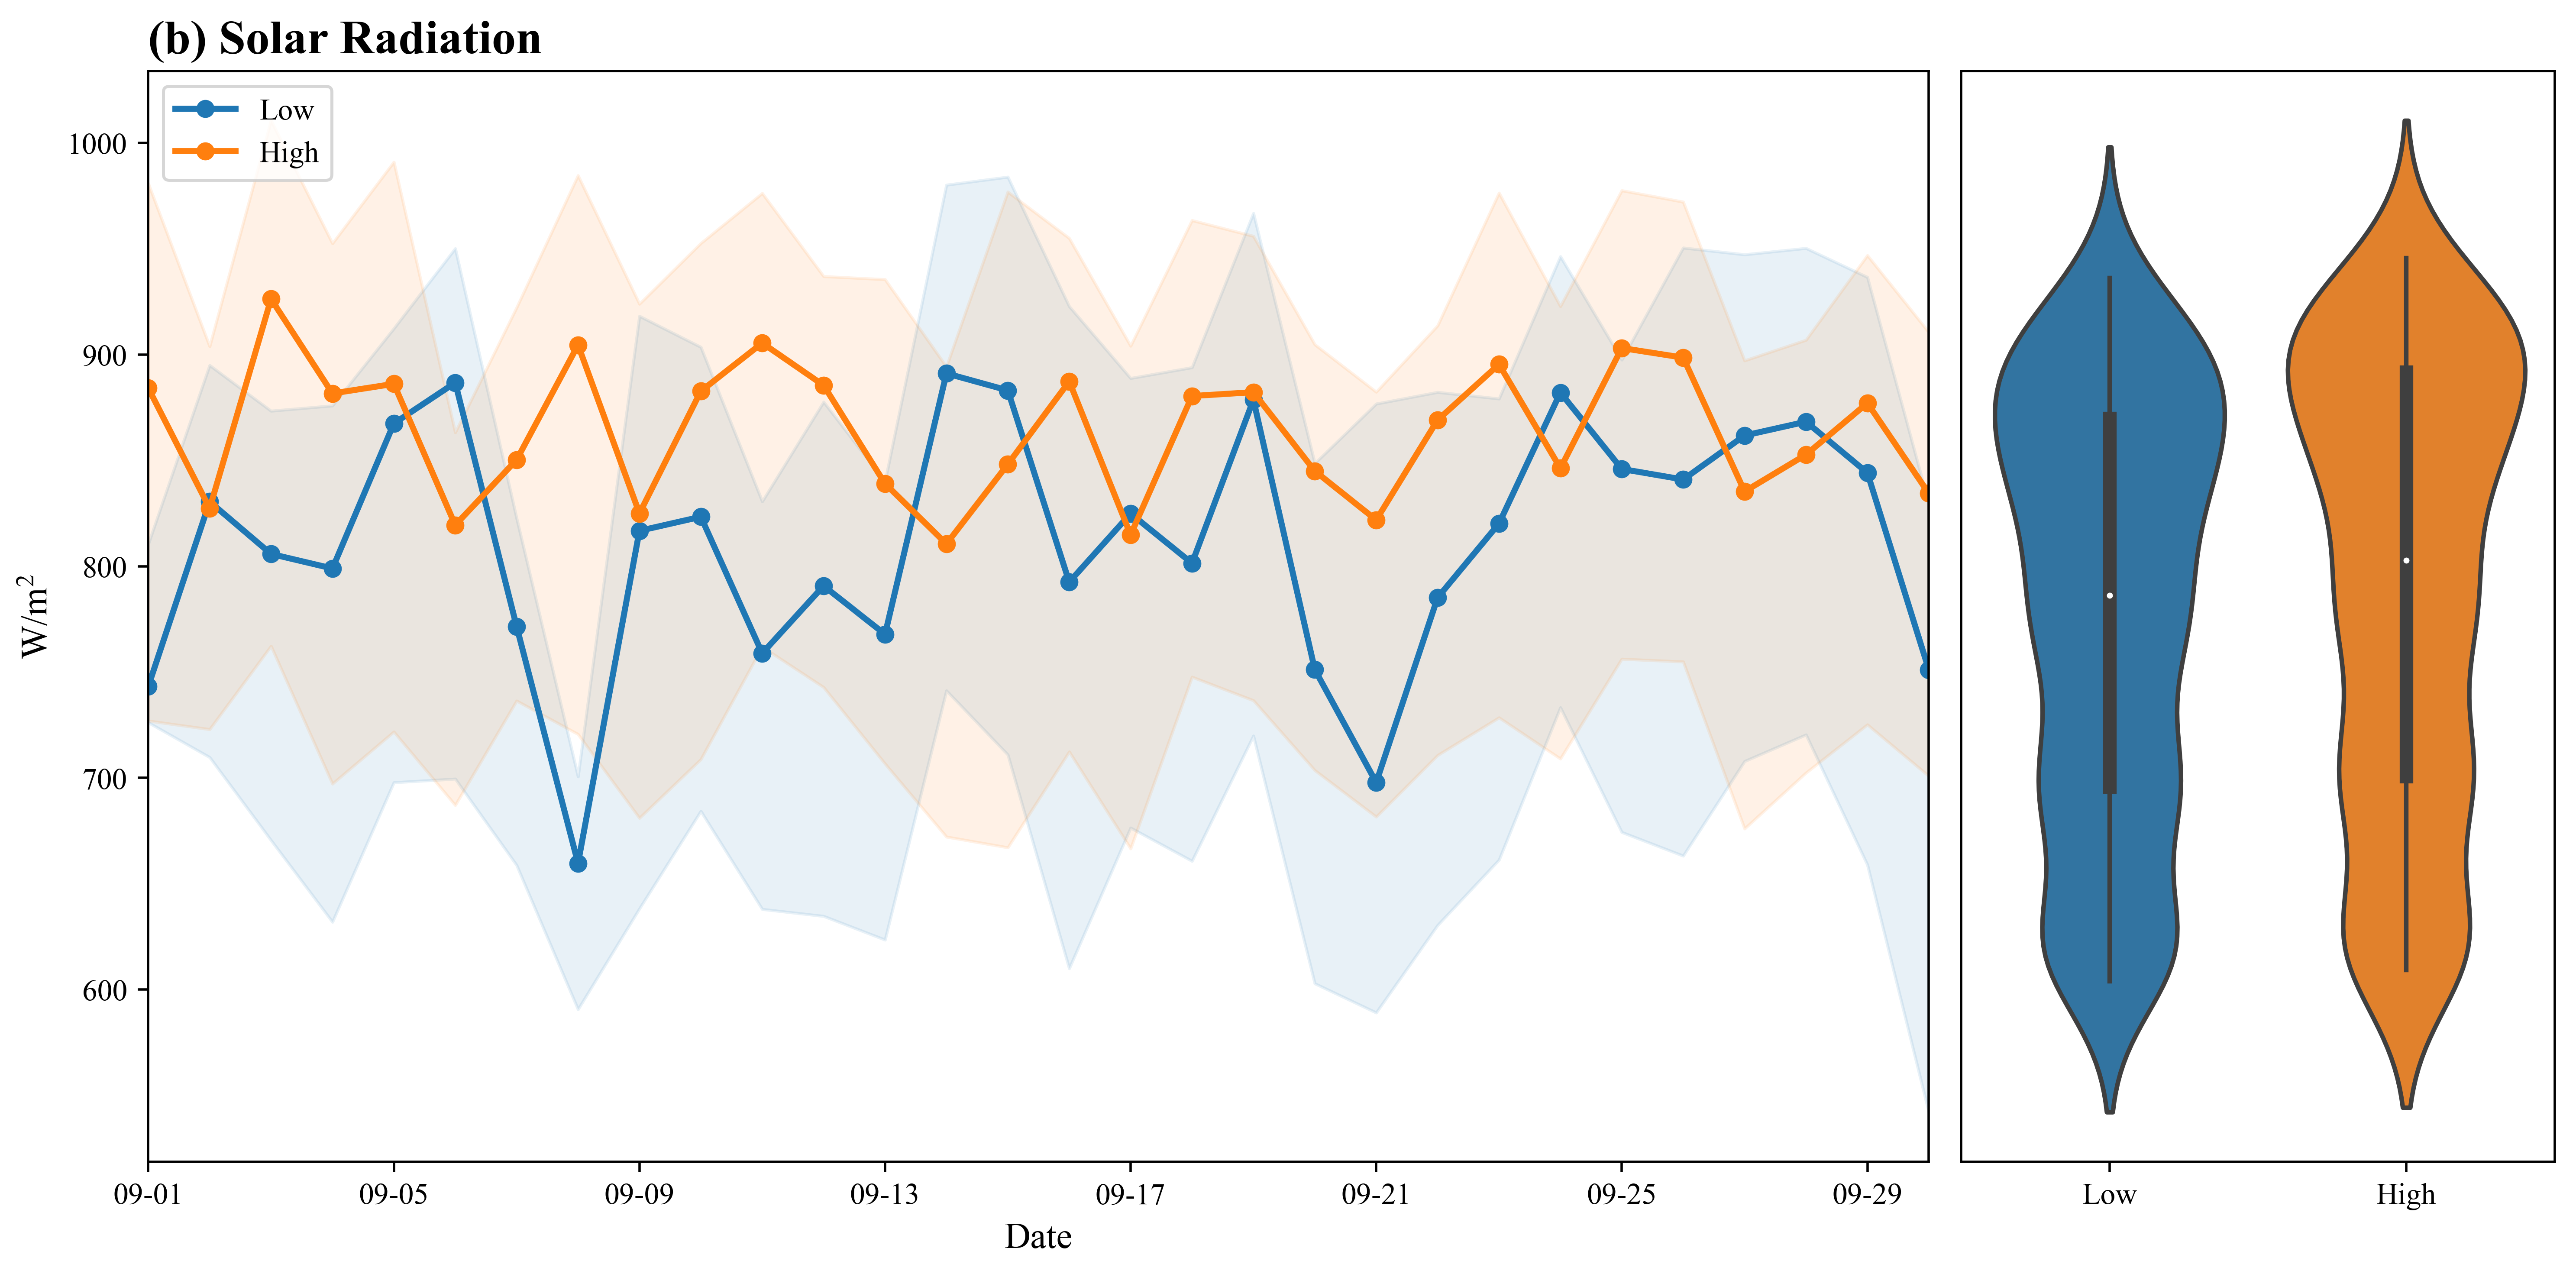

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=500, gridspec_kw={'width_ratios': [3, 1]})

xx = np.arange(0, len(max_low_day.time), 1)
# lower years
ax1.plot(xx, low_90per, color='tab:blue', linewidth=2, label='Low', marker='.', markersize=10)
ax1.fill_between(xx, max_low_day, low_80per, color='tab:blue', alpha=0.1)

ax1.plot(xx, high_90per, color='tab:orange', linewidth=2, label='High', marker='.', markersize=10)
ax1.fill_between(xx, max_high_day, high_80per, color='tab:orange', alpha=0.1)

# ticks and labels
ax1.set_xlim([0, len(max_low_day.time) - 1])
ax1.set_xticks(xx[::4])
ax1.set_xticklabels(pd.date_range('2023-09-01', '2023-09-30', freq='4D').strftime('%m-%d'))
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('W/m$^2$',fontsize=12)
ax1.legend(loc=2)
ax1.set_title('(b) Solar Radiation', loc='left', fontdict={'fontsize': 16, 'fontweight': 'bold'})

# 图2：小提琴图
df_box = pd.DataFrame({'Low': low_new.values, 'High': high_new.values})

color_palette = sns.color_palette(["tab:blue", "tab:orange"])
sns.violinplot(data=df_box, palette=color_palette, ax=ax2)

ax2.set_yticks([])

plt.tight_layout()
plt.show()